In [19]:
# Importing the Necessary Libraries
import sys
import numpy
import matplotlib.pyplot as plt
numpy.seterr(under='ignore')
import scipy.io.wavfile
import scipy.fftpack
import scipy.signal
import pylab

# Generally, number of samplepoints = len(wav_data)
def DrawFFT(sample_rate, wav_data, no_sample_points):
   N = no_sample_points
   # sample spacing
   T = 1.0 / sample_rate
   x = numpy.linspace(0.0, N*T, N)
   # y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
   y = wav_data[:N]
   plt.plot(x,y)
   yf = scipy.fftpack.fft(y)
   xf = numpy.linspace(0.0, 1.0/(2.0*T), N/2)

   # fig, ax = plt.subplots()
#    plt.figure(figsize=(20,10))
   plt.plot(xf, 2.0/N * numpy.abs(yf[:N//2]))

#    plt.show()

/home/exacon02/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


'\nNormalizing the .wav file\n'

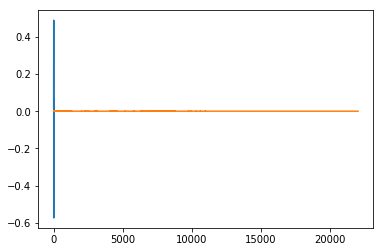

In [20]:
""" 
Reading the .wav file from which the noise is to be removed
It returns 
1.The sampling rate which is a single value and
2.Data from the wav file in the form of numpy array
""" 
sample_rate, wav_data = scipy.io.wavfile.read('/home/exacon02/Documents/Sounds/SoundPlusNoise.wav')
DrawFFT(sample_rate,wav_data,len(wav_data))
# wav_data=wav_data[:,:1]
# wav_data=wav_data.ravel()
"""
Normalizing the .wav file
"""
# wav_data = wav_data / float(numpy.iinfo(wav_data.dtype).max) 

In [21]:
wav_data.dtype

dtype('float32')

/home/exacon02/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


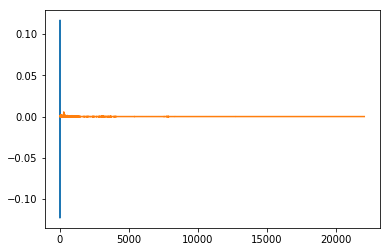

In [22]:
"""
Reading the .wavfile which only consist of noise to be removed.
In our case the noise file and the file from which the noise is to be removed
is the same since we want blank output.
"""

sample_rate, noise_data = scipy.io.wavfile.read('/home/exacon02/Documents/Sounds/Noise.wav')
DrawFFT(sample_rate,noise_data,len(noise_data))
# noise_data=noise_data[:,:1]
# noise_data = noise_data / float(numpy.iinfo(noise_data.dtype).max)
# smallsize = int(len(noise_data) / hopsize)

hopsize = min(len(wav_data),len(noise_data))
"""
Reshaping the file so that it can be Windowed.
"""

# noise_data = noise_data[:hopsize*smallsize]
noise_data = noise_data[:hopsize]
wav_data=wav_data[:hopsize]

noise_data = noise_data.reshape(1, hopsize) 

"""
Applying Hamming Windowing Method
"""
window = scipy.signal.get_window("hamming", hopsize)
noise_data=numpy.copy(noise_data)
noise_data *= window

"""
Taking FFT of the Windowed Noisy Data
FFT obtained is a numpy array in which each element is in the compex form
ie (x+iy)
"""

noise_ffts = scipy.fftpack.fft(noise_data, axis=1)

In [23]:
"""
Since each function is in complex form, we convert it into polar form(r,theta)
and use only 'r'
"""
noise_power = noise_ffts_abs = numpy.abs(noise_ffts)

# means_power=numpy.ravel(noise_power)

"""
Finding the power of the signal
"""
noise_power = noise_ffts_abs**2



"""
This mean is the noise estimate that will get subtracted 
"""
# print(noise_power)

# print(numpy.ravel(noise_power))

means_power = numpy.mean(noise_power, axis=0)
# print(means_power)

In [24]:
"""
Taking FFT of the signal from which the noise is to be removed and applying
Hamming Windowing Function
"""
# wav_data *=window
# wav_data=wav_data.reshape(1,hopsize)


fft = scipy.fftpack.fft(wav_data*window)


# takes the angle(in radian) of each tuple of x,y (x +iy)
# for fft of original data 
theta = numpy.angle(fft)

# some constant to not let the value of r go negative
alpha = 5.0
beta = 0.0005

# creates an array of len(fft) with all elements as 0
r = numpy.zeros(len(fft))  

# subtracts power of 'noise data' from fft of original data
cnt1=0
cnt2=0
for i in range(len(fft)):
    r[i] = (abs(fft[i])**2 - alpha * means_power[i])
    if r[i] < 0:
#         cnt1=cnt1+1
        r[i] = beta * means_power[i]
    r[i] = numpy.sqrt(r[i]) # why only sqrt 

        

# converts the complex number of recreated data (r,theta) to x +iy form
reconstructed = ( r * numpy.cos(theta)
    + r * numpy.sin(theta)*1j);


# taking the inverse fft of the recreated data
# in our case blank data should be obtained
reconstructed_sig = scipy.fftpack.ifft(reconstructed )

# extracting original data from the windowed data 
reconstructed_sig /= window

# taking the real data of the data that was represented in complex form
reconstructed_sig = numpy.real(reconstructed_sig)

# the int16 format is what the libraries format of storing data of wav file is. 
big = numpy.int16(reconstructed_sig * numpy.iinfo(numpy.int16).max)

# writing data to a wav file, sample rate is as of the orginal data
# big = dtype format of the data 
scipy.io.wavfile.write("/home/exacon02/Documents/Sounds/Output.wav", sample_rate, big)